## Import Packages and Loading Data
--------

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import time
import datetime

In [3]:
plt.rcParams['figure.figsize'] = (10,8) 
plt.rcParams['lines.linewidth'] = 0.5
plt.style.use('fivethirtyeight')

In [4]:
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [6]:
import warnings 
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)

In [7]:
ticker = 'BTC-AUD'
period1 = int(time.mktime(datetime.datetime(2017, 2, 25, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 25, 23, 59).timetuple()))
interval = '1d'

In [8]:
url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(url)

In [11]:
df.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-25,1526.157349,1531.946777,1466.410156,1491.511230,1491.511230,182502271
1,2017-02-26,1492.072021,1522.323608,1473.725342,1519.958252,1519.958252,151951474
2,2017-02-27,1518.105957,1537.234985,1516.990479,1537.420166,1537.420166,171426710
3,2017-02-28,1538.397339,1553.508667,1524.417725,1544.059082,1544.059082,242025648
4,2017-03-01,1544.150757,1596.786865,1539.060547,1596.786865,1596.786865,299186249
5,2017-03-02,1599.634399,1669.263306,1588.630371,1652.152710,1652.152710,486364247
6,2017-03-03,1651.756470,1693.979980,1652.192871,1678.943848,1678.943848,415774306
7,2017-03-04,1682.156982,1684.751099,1620.371338,1652.817993,1652.817993,241335265
8,2017-03-05,1651.685547,1669.024170,1630.313477,1668.800171,1668.800171,176645595
9,2017-03-06,1669.261108,1677.622925,1669.659302,1676.982788,1676.982788,202446630


In [12]:
df.shape

(1827, 7)

In [13]:
print(df['Date'].min())
print(df['Date'].max())

2017-02-25
2022-02-25


The Stock Price for 1827 days are given in this dataset, starting from 25th Feb 2017 to 25th Feb 2022.

Text(0, 0.5, 'AUD($)')

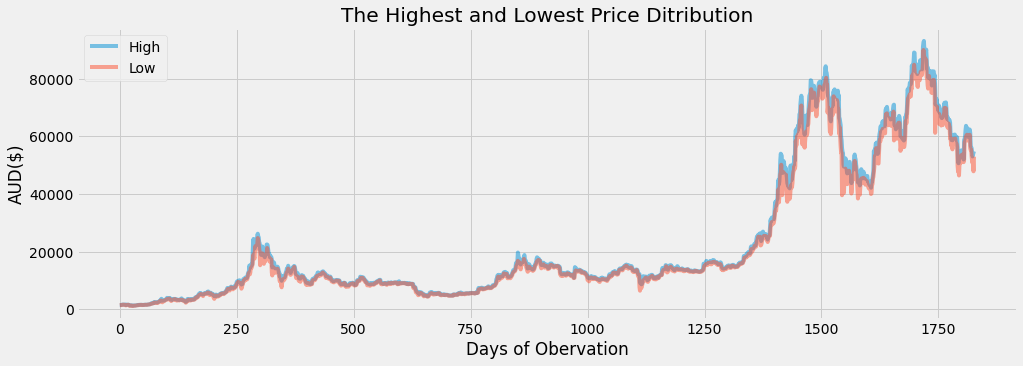

In [105]:
df[['High', 'Low']].plot(figsize = (15, 5), alpha = 0.5)
plt.title("The Highest and Lowest Price Ditribution")
plt.xlabel('Days of Obervation')
plt.ylabel('AUD($)')

Text(0, 0.5, 'AUD($)')

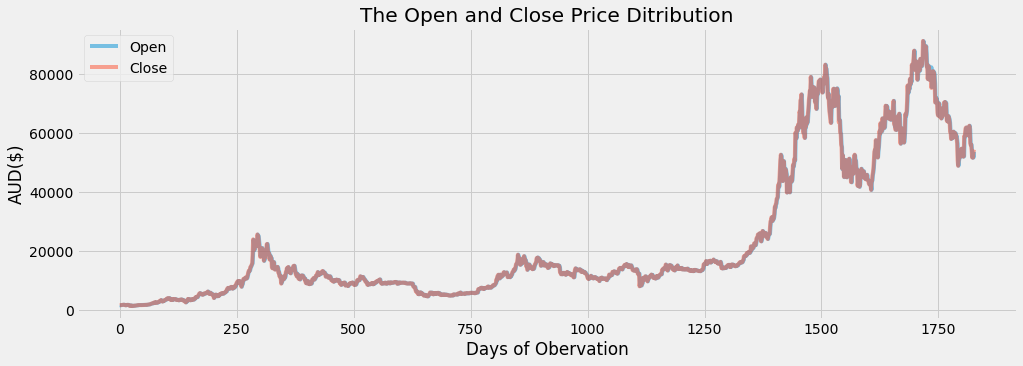

In [106]:
df[['Open', 'Close']].plot(figsize = (15, 5), alpha = 0.5)
plt.title("The Open and Close Price Ditribution")
plt.xlabel('Days of Obervation')
plt.ylabel('AUD($)')

We can observe that there are no huge variations in the opening-closing price and the high-low prices.

There were huge peaks in the stock prices 2 times, once close to 2018(due to cryptocurrency bubble) and once in 2021(owing to Twitter action by Elon Musk).

There was an overall increase in the stock price from the start point to today.

The stock prices started to increase from the latter half for the year 2020

In [16]:
df.isna().sum().sort_values(ascending = False)

Volume       0
Adj Close    0
Close        0
Low          0
High         0
Open         0
Date         0
dtype: int64

## Feature Engineering
---------

### Day of Week Analysis

In [90]:
dfClose = df[['Date', 'Close']].copy() 
dfClose['Date'] = pd.to_datetime(dfClose['Date'])
dfClose['Day_of_week'] = dfClose['Date'].dt.weekday

dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(0,'Monday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(1,'Tuesday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(2,'Wednesday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(3,'Thursday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(4,'Firday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(5,'Saturday')
dfClose['Day_of_week'] = dfClose['Day_of_week'].replace(6,'Sunday')

dfClose.set_index('Date', inplace = True)

dfClose = dfClose.fillna(method  = 'bfill') 

dfClose.tail(15) 

,Close,Day_of_week
Date,,
2022-02-11,59430.949219,Firday
2022-02-12,59196.289063,Saturday
2022-02-13,59065.042969,Sunday
2022-02-14,59713.207031,Monday
2022-02-15,62358.480469,Tuesday
2022-02-16,61125.097656,Wednesday
2022-02-17,56404.632813,Thursday
2022-02-18,55800.097656,Firday
2022-02-19,55927.195313,Saturday


In [91]:
combine = dfClose.groupby(['Day_of_week'])['Close'].sum().reset_index()


In [92]:
c= combine.sort_values(by = 'Day_of_week',ascending = False)
c

,Day_of_week,Close
6,Wednesday,5.938829e+06
5,Tuesday,5.920958e+06
4,Thursday,5.928195e+06
3,Sunday,5.918806e+06
2,Saturday,5.915970e+06
1,Monday,5.924878e+06
0,Firday,5.952856e+06


### Daily Fluctuation

In [95]:
dfOpen_Close = df[['Date', 'Close','Open']].copy() 
dfOpen_Close['Date'] = pd.to_datetime(dfOpen_Close['Date'])

In [98]:
dfOpen_Close['Daily_difference'] = dfOpen_Close['Close'] - dfOpen_Close['Open']
dfOpen_Close

,Date,Close,Open,Daily_difference
0,2017-02-25,1491.511230,1526.157349,-34.646119
1,2017-02-26,1519.958252,1492.072021,27.886231
2,2017-02-27,1537.420166,1518.105957,19.314209
3,2017-02-28,1544.059082,1538.397339,5.661743
4,2017-03-01,1596.786865,1544.150757,52.636108
...,...,...,...,...
1822,2022-02-21,51605.378906,53574.941406,-1969.562500
1823,2022-02-22,52978.136719,51596.320313,1381.816406
1824,2022-02-23,51601.746094,52977.105469,-1375.359375
1825,2022-02-24,53536.781250,51576.832031,1959.949219


Text(0, 0.5, 'AUD($)')

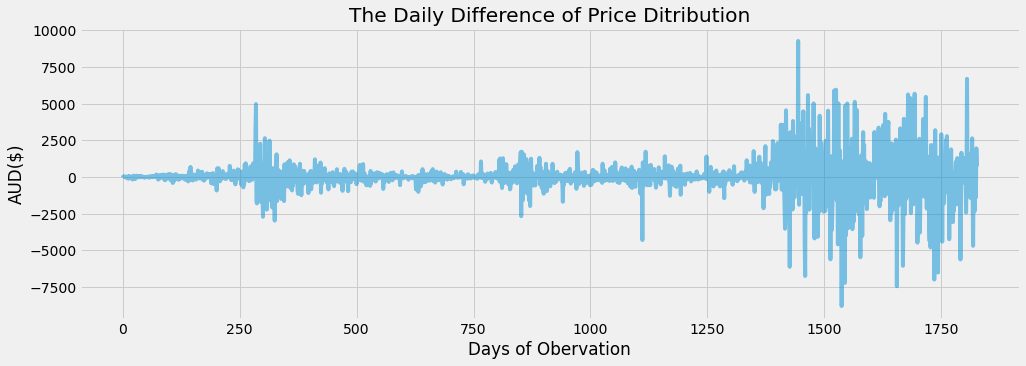

In [107]:
dfOpen_Close['Daily_difference'].plot(figsize = (15, 5), alpha = 0.5)
plt.title("The Daily Difference of Price Ditribution")
plt.xlabel('Days of Obervation')
plt.ylabel('AUD($)')

We see a huge fluctuation of price in one day, espcially around 2021.

## Get Ready for Modelling
--------

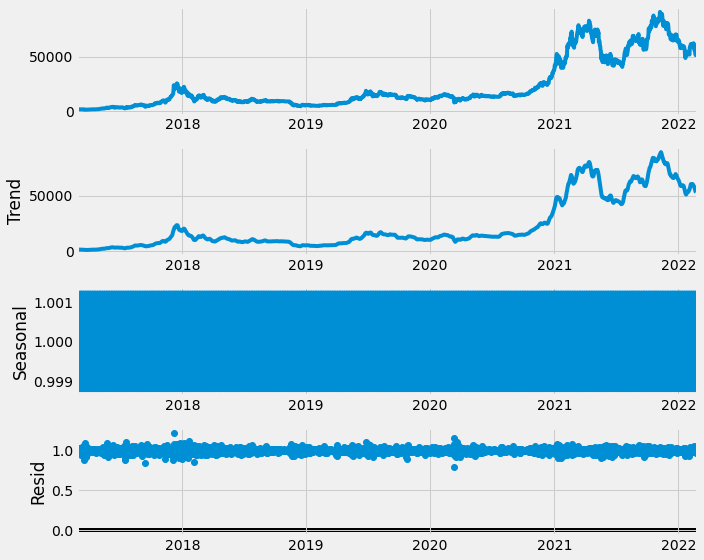

In [18]:
decomp = seasonal_decompose(dfClose, model = "multiplicative") 
x = decomp.plot() 

To stabilize the variance of a series

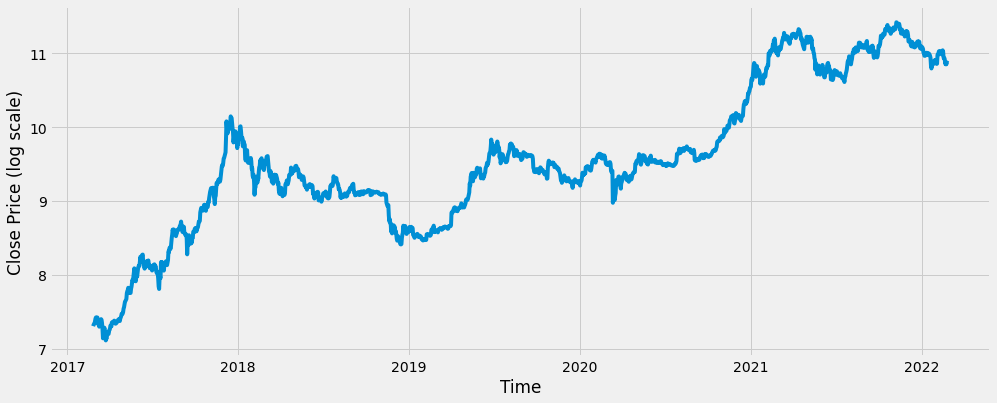

In [19]:
# Apply log transformation to all observations
dfClose = np.log(dfClose) 

# Plot the log-transformed series
plt.figure(figsize = (15,6))
plt.plot(dfClose.index, dfClose)
plt.xlabel('Time')
plt.ylabel('Close Price (log scale)')
plt.show()

### Moving average smoothing

It is also possible to visualize rolling averages of the values in your time series. This is equivalent to "smoothing" your data, and can be particularly useful when your time series contains a lot of noise or outliers.

In [20]:
dfClose_CMA52 = dfClose.rolling(52,center=True).mean()

dfClose_CMA120 = dfClose.rolling(120,center=True).mean().rolling(2,center=True).mean().shift(-1)

dfClose_CMA365 = dfClose.rolling(365,center=True).mean().rolling(2,center=True).mean().shift(-1)

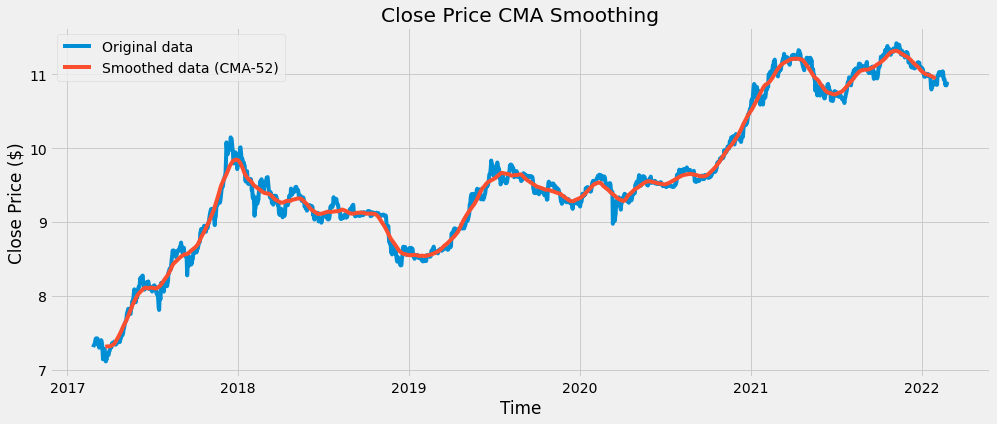

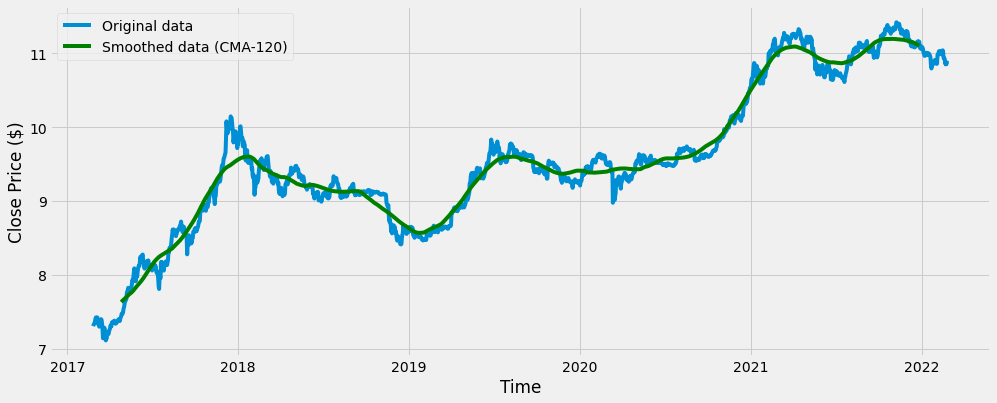

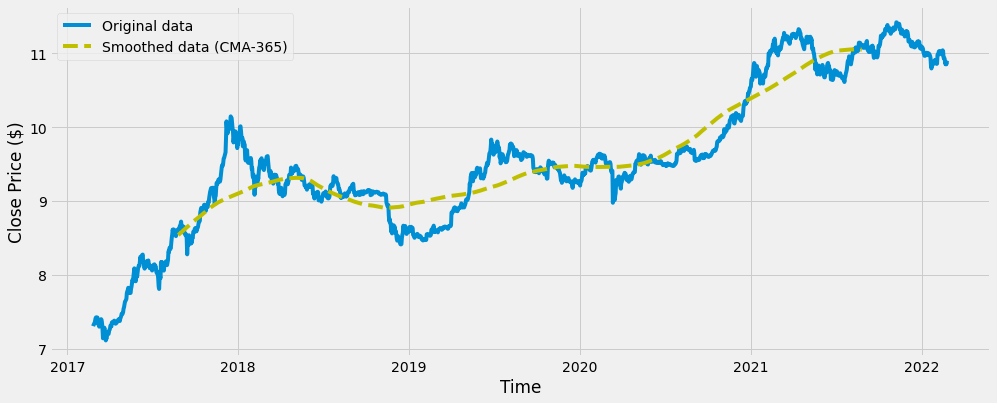

In [21]:
# Plot the original and smooth series
plt.figure(figsize=(15,6))
plt.plot(dfClose)
plt.plot(dfClose_CMA52)
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.title('Close Price CMA Smoothing')
plt.legend(['Original data','Smoothed data (CMA-52)'])
plt.savefig('MA-52')

plt.figure(figsize=(15,6))
plt.plot(dfClose)
plt.plot(dfClose_CMA120,'g')
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.legend(['Original data','Smoothed data (CMA-120)'])
plt.savefig('MA-120')

plt.figure(figsize=(15,6))
plt.plot(dfClose)
plt.plot(dfClose_CMA365,'--y')
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.legend(['Original data','Smoothed data (CMA-365)'])
plt.savefig('MA-365')

### Prediction Using CMA52

                Close  Pred_one_step_MA52
Date                                     
2022-01-01  11.091996           11.209862
2022-01-02  11.084437           11.204089
2022-01-03  11.075366           11.198072
2022-01-04  11.057318           11.192226
2022-01-05  11.007797           11.185940
2022-01-06  11.005600           11.178405
2022-01-07  10.966261           11.171431
2022-01-08  10.970021           11.164641
2022-01-09  10.974836           11.157771
2022-01-10  10.972442           11.152140
2022-01-11  10.989939           11.145950
2022-01-12  11.007967           11.139581
2022-01-13  10.976690           11.133872
2022-01-14  10.998804           11.128366
2022-01-15  11.000605           11.122839
2022-01-16  10.998944           11.117728
2022-01-17  10.978314           11.112173
2022-01-18  10.984577           11.107371
2022-01-19  10.965584           11.102248
2022-01-20  10.939703           11.095977
2022-01-21  10.835262           11.089029
2022-01-22  10.795332           11

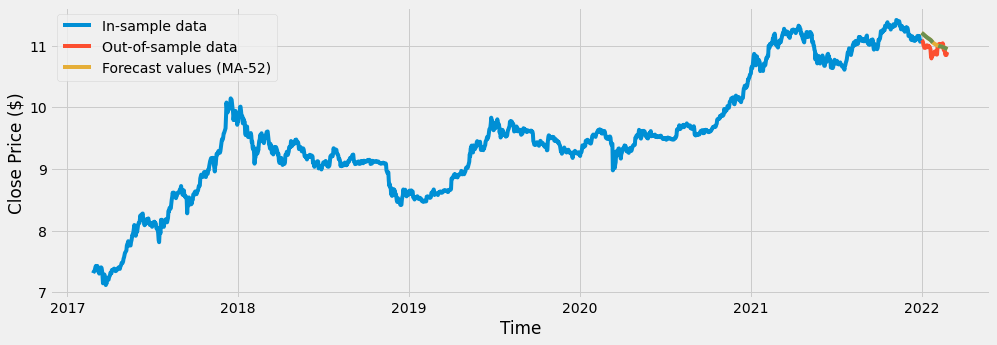

In [22]:
# Extract data for in-sample period (2017-2021)
dfClose_in = dfClose['2017':'2021']
Close_in = len(dfClose_in) 

# Extract data for out-of-sample period (2022)
dfClose_out = dfClose['2022']
Close_out = len(dfClose_out)

# Get the MA-52 series and then extract corresponding smoothed values to make one-step-ahead forecast
dfClose_rolling = dfClose.rolling(52).mean()
dfClose_one_step_MA = dfClose_rolling[-Close_out-1:-1].to_numpy()  

# It is useful to put true and forecast for out-out-sample data in the same DataFrame
dfClose_forecast_df = pd.DataFrame(dfClose_out)
dfClose_forecast_df['Pred_one_step_MA52'] = dfClose_one_step_MA
print(dfClose_forecast_df)

# Then plot the original and forecast data
plt.figure(figsize=(15,5))
plt.plot(dfClose_in)
plt.plot(dfClose_out)
plt.plot(dfClose_forecast_df['Pred_one_step_MA52'],'--')
plt.legend(['In-sample data','Out-of-sample data','Forecast values (MA-52)'])
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.show()

In [23]:
# report performance
rmse = math.sqrt(mean_squared_error(dfClose_out['Close'], dfClose_forecast_df['Pred_one_step_MA52']))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(dfClose_forecast_df['Pred_one_step_MA52'] - dfClose_out['Close'])/np.abs(dfClose_out['Close']))
print('MAPE: '+str(mape))

RMSE: 0.13330313858232554
MAPE: 0.010356628606147264


### Assign Stationary

In [24]:
print("ADFuller Test; Significance: 0.05") #Print the significance level
adf = adfuller(dfClose['Close']) #Call adfuller to test
print("ADF test static is {}".format(adf[1])) #Print the adfuller results

ADFuller Test; Significance: 0.05
ADF test static is 0.3661792751818815


Can't reject H0 where it is non-stationary

### Train-Test Split

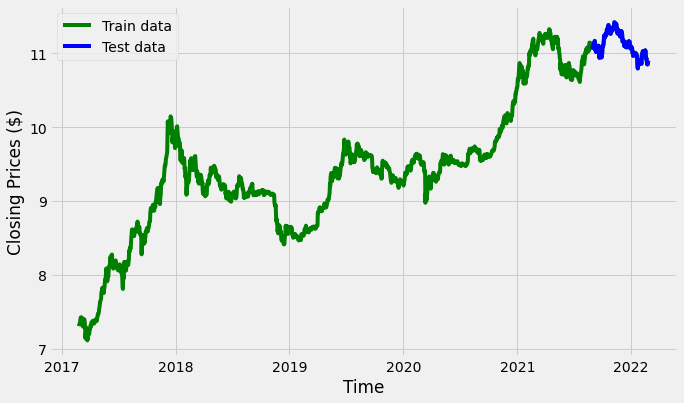

In [25]:
train_data, test_data = dfClose[3:int(len(dfClose)*0.9)], dfClose[int(len(dfClose)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Closing Prices ($)')
plt.plot(dfClose, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5700.911, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5700.869, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5700.691, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5698.202, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5700.856, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.210 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1641
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2852.455
Date:                Tue, 01 Mar 2022   AIC                          -5700.911
Time:                        20:34:57   BIC                          -5690.106
Sample:                             0   HQIC                         -5696.904
                               - 1641                                  

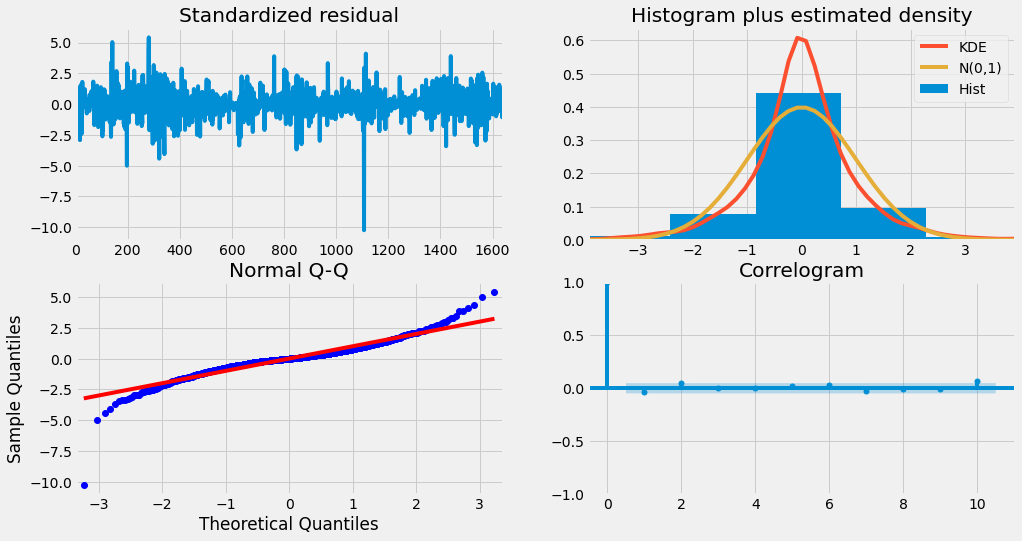

In [27]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

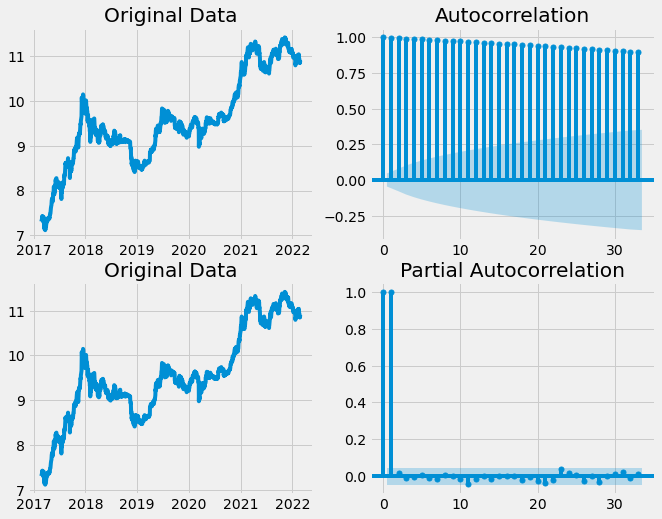

In [28]:
fig,axes = plt.subplots(2,2) 

a = axes[0,0].plot(dfClose['Close']) 
a = axes[0,0].set_title('Original Data') 
b = plot_acf(dfClose['Close'],ax=axes[0,1]) #Plot the ACF of the original data

x = axes[1,0].plot(dfClose['Close']) 
x = axes[1,0].set_title('Original Data') 
y = plot_pacf(dfClose['Close'],ax=axes[1,1]) #Plot the PACF of the original data

In [29]:
model = ARIMA(train_data, order=(0,1,0))
fitted = model.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

In [30]:
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1640
Model:                 ARIMA(0, 1, 0)   Log Likelihood                2852.455
Method:                           css   S.D. of innovations              0.043
Date:                Tue, 01 Mar 2022   AIC                          -5700.911
Time:                        20:35:12   BIC                          -5690.106
Sample:                    03-01-2017   HQIC                         -5696.904
                         - 08-26-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.172      0.030       0.000       0.004


In [31]:
# Forecast
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

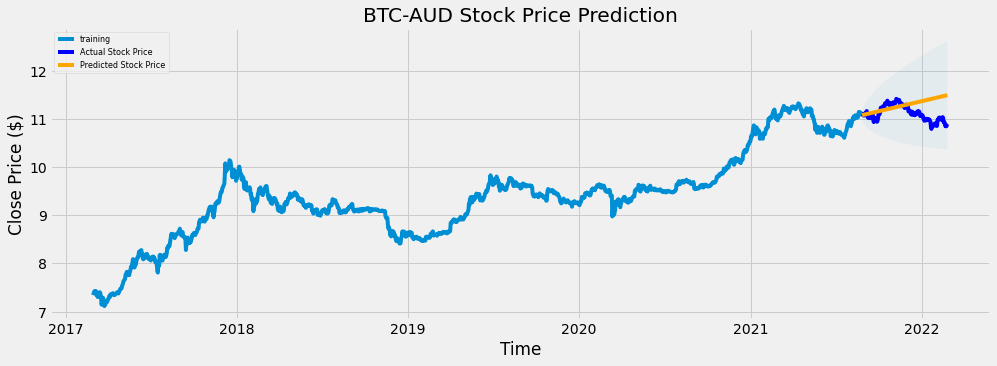

In [32]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(15,5))
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.05)

plt.title('BTC-AUD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
# report performance
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

fc = fc.reshape(183,1)
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

RMSE: 0.29307588645574756
MAPE: Close    0.020196
dtype: float64
